# Introduction and Pre-Processing

In this notebook, we explore a handful of the preprocessing tools BART offers.

### Setup

If you are runnning locally, you will need [BART](https://www.github.com/mrirecon/bart) as well as [View](https://www.github.com/mrirecon/view), an open-source tool to view data. Once both are installed, add the necessary directories to your `PATH`. You can do this in your bash session with `export PATH=/path/to/bart:/path/to/view:$PATH`. Make sure to change the placeholder directories to the directories where you have BART and View installed.

The following cell defines an image viewer function that allows us to display 2D images inline. `bart toimg` converts a BART image to a png file.

In [2]:
# BASH function to write BART file to png,
# display the png, and then temove it
function imshow () {
    bart toimg -W $1 $1.png
    cat $1.png | display
    rm $1.png
}

### File Formats and Metadata

Throughout this notebook, we will be pre-processing and reconstructing a slice of the 3D FSE Scan of a knee.

The data is available [here](http://old.mridata.org/fullysampled/knees) if you are looking to recreate these results on your own, or experiment on other MR datasets. The following cell will download and unpack the data for ease of use and navigation

In [40]:
wget http://old.mridata.org/knees/fully_sampled/p1/e1/s1/P1.zip
unzip P1.zip
mv p1/e1/s1/* .
rmdir p1

--2020-05-14 14:35:33--  http://old.mridata.org/knees/fully_sampled/p1/e1/s1/P1.zip
Resolving old.mridata.org (old.mridata.org)... 108.179.232.58
Connecting to old.mridata.org (old.mridata.org)|108.179.232.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1429761117 (1.3G) [application/zip]
Saving to: ‘P1.zip’

P1.zip              100%[===================>]   1.33G  4.88MB/s    in 4m 56s  

2020-05-14 14:40:29 (4.61 MB/s) - ‘P1.zip’ saved [1429761117/1429761117]

Archive:  P1.zip
   creating: p1/e1/s1/
  inflating: p1/e1/s1/params.txt     
  inflating: p1/e1/s1/kspace.cfl     
  inflating: p1/e1/s1/kspace.hdr     
  inflating: p1/e1/s1/GEheader.txt   
rmdir: p1: Directory not empty


: 1

Before viewing the image, we are going to use `bart show` to get a better understanding of the data we are working with. 

BART data is stored in two files, a header (`.hdr`) file which contains metadata (dimensions, file type, etc.) and a complex float (`.cfl`) file which contains the raw data. The header file can be opened as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in row-major order with interleaved real and imaginary components.

By default, `show` will print the contents of the `.cfl` file. To view the metadata, append the `-m` flag to the command.

In [6]:
bart show -m kspace

Type: complex float
Dimensions: 16
AoD:	320	320	256	8	1	1	1	1	1	1	1	1	1	1	1	1


More explicitly, `-d` will show us the dimension along a specific axis.

In [25]:
 bart show -d 2 kspace

256


We are working with k-space data of 320 values in the spatial frequency/$k_x$ direction, and 320 values in the phase encoding/$k_y$ direction. As shown in the previous cell, we have 256 slices along the readout direction. The data has been collected from 8 coils. Let's take a look in `view`.

View has a handful of parameters that let users adjust the zoom and magnitude cutoff for the displayed images. The default settings make it difficult to see the full variation in k-space data. Adjust the second slider (upper magnitude threshold) to 0.001 to best view the images. 

In [2]:
view kspace&

[1] 2513


### Performing Inverse FFT Along the Readout Direction

Prior to extracting a slice, we perform an inverse FFT along the readout direction of our 3D Data.

#### Bitmasks
To specify the dimensions BART operates on, one must pass in an appropriate bitmask (e.g., for dimensions 0 and 1, this bitmask is calculated as $2^0 + 2^1 = 3$). `bart bitmask` automatically computes this value for us.

In [26]:
bart bitmask -h

Usage: bitmask [-b] -b <bitmask> | <dim1> ... <dimN>

Convert between a bitmask and set of dimensions.

-b		dimensions from bitmask
-h		help


We can perform the reverse operation as well. Passing in a bitmask and using the flag `-b`, the command will return the dimensions it specifies.

In [27]:
bart bitmask -b 3

0 1 


#### Inverse FFT

In [28]:
bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


`-u` and `-i` indicate that we want a unitary and inverse FFT respectively. Out bitmask refers to the readout dimension (`2`).

In [29]:
bart fft -u -i $(bart bitmask 2) kspace kspace_fft

Let's examine the dimensions of the result of applying the inverse FFT, and take a look in view. 

In [30]:
bart show -m kspace_fft

Type: complex float
Dimensions: 16
AoD:	320	320	256	8	1	1	1	1	1	1	1	1	1	1	1	1


In [6]:
view kspace_fft&

[1] 2519


### Extracting a Slice Along the Readout Direction

`bart slice` allows us to extract a designated slice of an image along a specified dimension. We will extract a slice along the readout direction to later perform an FFT on. 

In [8]:
bart slice -h

Usage: slice dim1 pos1 ... dimn posn <input> <output>

Extracts a slice from positions along dimensions.


-h		help


We want to extract slice `128` from the readout direction `2`. Therefore, our command looks like:

In [31]:
bart slice 2 128 kspace_fft ksp_slice

Using `show` we verify that our slice dimensions look correct.

In [32]:
bart show -m ksp_slice

Type: complex float
Dimensions: 16
AoD:	320	320	1	8	1	1	1	1	1	1	1	1	1	1	1	1


Dimensions look good! We have preserved the $k_x$ and $k_y$ dimensions as well as the number of coils, but have taken one of the 256 original slices along the $z-$dimension. Let's look at the image in `view`

In [12]:
view ksp_slice&

[1] 2527


: 1

### Resizing

`bart resize` can be used to manipulate data. We'll briefly explore resizing our slice with the tool.

In [14]:
bart resize -h

Usage: resize [-c] dim1 size1 ... dimn sizen <input> <output>

Resizes an array along dimensions to sizes by truncating or zero-padding.

-c		center
-h		help


In [33]:
bart resize -c 0 160 1 160 ksp_slice resized_slice

In [16]:
bart show -m resized_slice

Type: complex float
Dimensions: 16
AoD:	160	160	1	8	1	1	1	1	1	1	1	1	1	1	1	1


In [43]:
view resized_slice&

[14] 2084


: 1

We have sucessfully resized both the $x$ and $y$ dimensions!

### Coil Compression

We will now use BART's build in coil compression method, `cc`, to compress to four virtual coils. The `-G` flag enables [Geometric](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.24267) coil compression, but additional flags offer SVD and ESPIRiT based methods as well.

In [34]:
bart cc -p 4 -G ksp_slice ksp_cc

Done.


`-p` allows us to specify the number of virtual coils we wish to compress to.

In [18]:
bart show -m ksp_cc

Type: complex float
Dimensions: 16
AoD:	320	320	1	4	1	1	1	1	1	1	1	1	1	1	1	1


Dimension `3` - the number of coils - has changed to reflect our compression. This looks good, let's take a look at the image in `view`.

In [19]:
view ksp_cc&

[1] 2535


: 1

Note that in now we can only toggle the four virtual coils on the right-hand column.

### Reconstruction via FFT

Now, we're going to apply a basic inverse FFT to the K-Space slice to reconstruct the Knee image. Once again, we specify a bitmask, but this time we want to apply our FFT to the dimensions `0` and `1`, or reconstruct our image signal from the spatial frequency and phase encoding dimensions, respectively.

In [35]:
bart fft -i -u $(bart bitmask 0 1) ksp_cc knee

In [36]:
view knee&

[1] 2575


: 1

### Reshaping Multi-Dimensional Data and Scripting

`bart reshape` allows us to reshape multi-dimensional data. Here, we use it to view the differences in sensitivity across the four virtual coils.

In [61]:
bart reshape -h

Usage: reshape flags dim1 ... dimN <input> <output>

Reshape selected dimensions.


-h		help


Writing 1 image(s)...done.


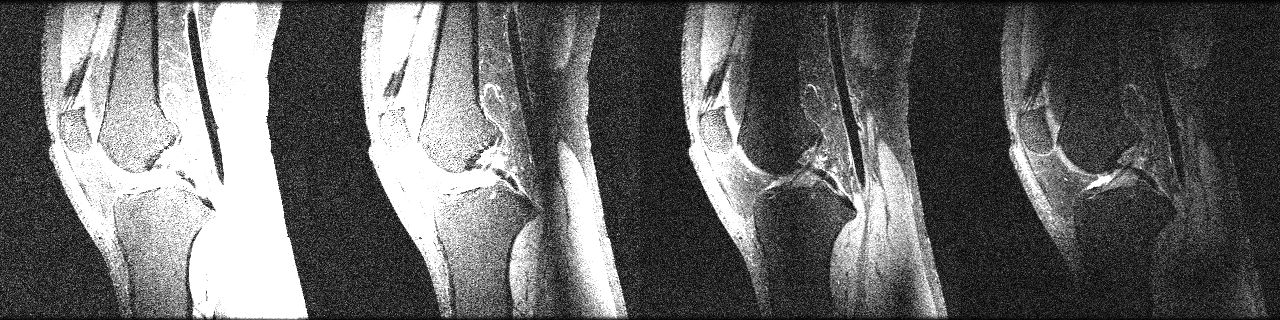

In [3]:
bart reshape $(bart bitmask 1 3) 1280 1 knee knee_flat
imshow knee_flat

The BART command-line tools make it easy to seemlessly integrate BART tools into bash scripts. It can be useful to script new tools and consolidate common processes for later use. The following cell contains a function used to flatten multi-coil images.

Usage: `flatten <data> <output>`

In [52]:
function flatten(){
    # The flattened image's dimensions are calculated as (num coils) * (slice dims)
    # get the slice dimensions and number of coils
    let slice_dim=$(bart show -d 1 $1)
    let coils=$(bart show -d 3 $1)
    
    let "flat_dim = slice_dim * coils"
    
    bart reshape $(bart bitmask 1 3) $flat_dim 1 $1 $2
}

To demonstrate let's take a look at our k-space slice, collected across 8 coils.

bash: flatten: command not found
Writing 1 image(s)...done.


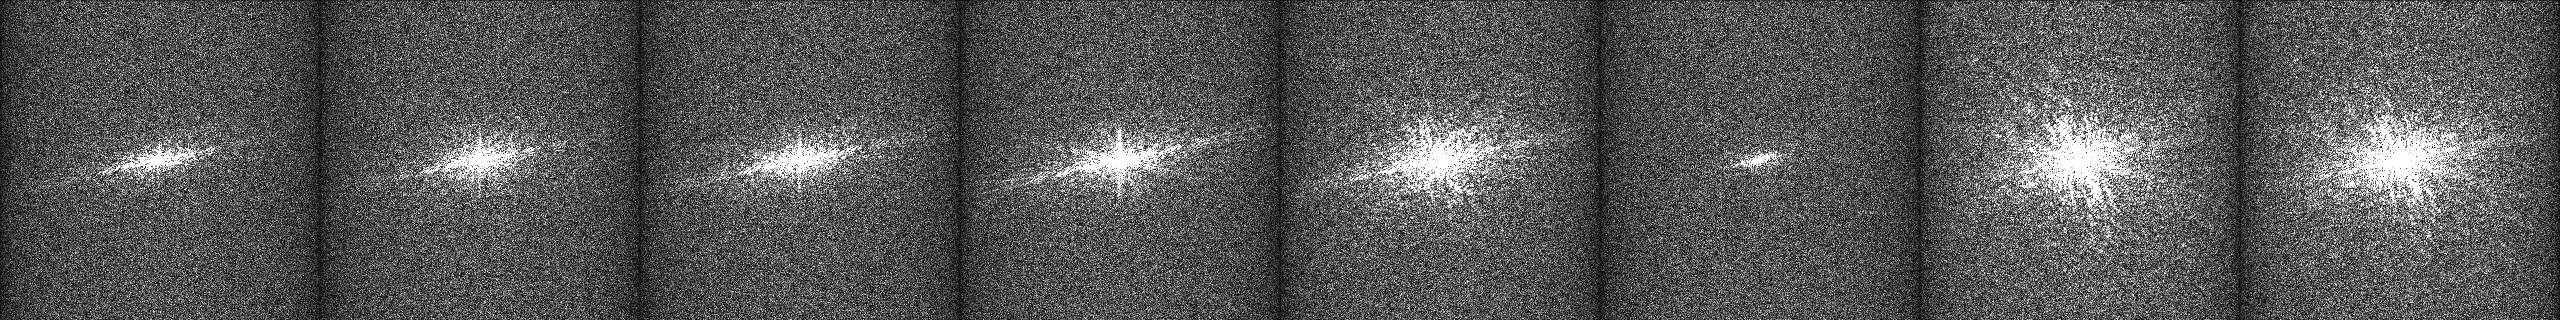

In [38]:
flatten ksp_slice slice_flat
imshow slice_flat

### Combining Multi-Coil Images

To wrap up, let's combine the coils using a Root-Sum-of-Squares (`rss`) calculation as follows:

In [4]:
bart rss $(bart bitmask 3) knee knee_complete

In [59]:
view knee_complete&

[1] 2216


: 1

Writing 1 image(s)...done.


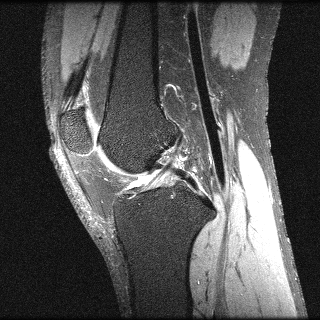

In [5]:
imshow knee_complete